In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# **1-Import Modules**

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
from PIL import Image

warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from keras import initializers, layers
import keras.backend as K
from keras.preprocessing.image import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input, BatchNormalization

# **2-Load the Dataset**

In [3]:
BASE_DIR = '/kaggle/input/utkface-new/UTKFace'

<div style="background-color: green; padding: 20px; border-radius: 25px; ">
<font color='white' size="5px">
labels - age, gender, ethnicity
    </font>
</div>

In [4]:
image_paths = []
age_labels = []
gender_labels = []

for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR, filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)

  0%|          | 0/23708 [00:00<?, ?it/s]

<div style="background-color: green; padding: 20px; border-radius: 25px; ">
<font color='white' size="5px">
convert to dataframe
    </font>
</div>

In [5]:
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.head()

,image,age,gender
0,/kaggle/input/utkface-new/UTKFace/26_0_2_20170...,26,0
1,/kaggle/input/utkface-new/UTKFace/22_1_1_20170...,22,1
2,/kaggle/input/utkface-new/UTKFace/21_1_3_20170...,21,1
3,/kaggle/input/utkface-new/UTKFace/28_0_0_20170...,28,0
4,/kaggle/input/utkface-new/UTKFace/17_1_4_20170...,17,1


<div style="background-color: green; padding: 20px; border-radius: 25px; ">
<font color='white' size="5px">
map labels for gender
    </font>
</div>

In [6]:
gender_dict = {0:'Male', 1:'Female'}

<div style="background-color: green; padding: 20px; border-radius: 25px; ">
<font color='white' size="5px">
to display grid of images
    </font>
</div>

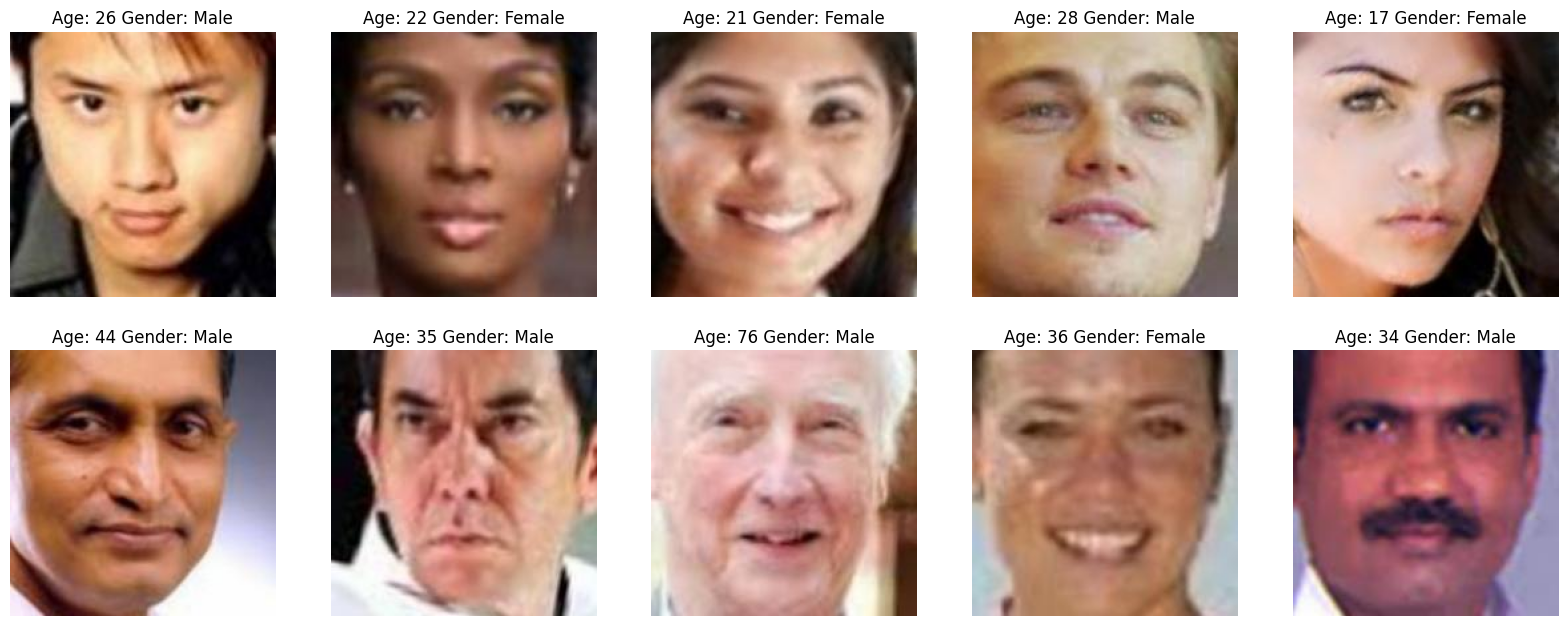

In [7]:
plt.figure(figsize=(20, 20))
files = df.iloc[0:10]

for index, file, age, gender in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
    plt.axis('off')

# **3-Data Analysis**

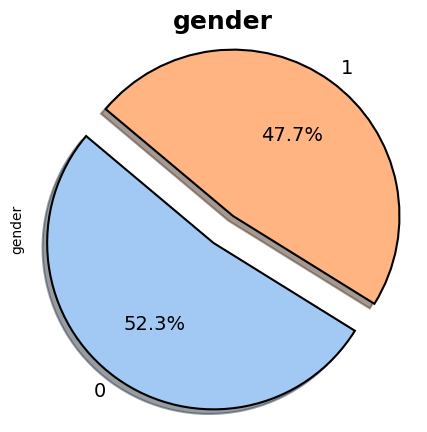

In [8]:
def plot_data(name, data):
    plt.figure(figsize=(5, 5))
    palette_color = sns.color_palette('pastel')
    explode = [0.1 for _ in range(data.nunique())]

    target_counts = df.groupby(name)[name].count()

    target_counts.plot.pie(
    colors=palette_color,
    explode=explode,
    autopct="%1.1f%%",
    shadow=True,
    startangle=140,
    textprops={'fontsize': 14},
    wedgeprops={'edgecolor': 'black', 'linewidth': 1.5} 
    )

    plt.title(name, fontsize=18, weight='bold')
    plt.axis('equal')
    plt.show()


plot_data('gender', df['gender'])

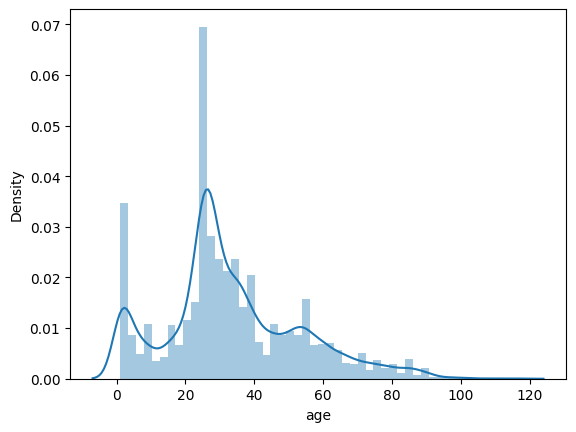

In [9]:
sns.distplot(df['age']);

# **4-Feature Extraction**

<div style="background-color: green; padding: 20px; border-radius: 25px; ">
<font color='white' size="5px">
extract features and normalize the images
    </font>
</div>

In [10]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, color_mode='grayscale')
        img = img.resize((128, 128), Image.Resampling.LANCZOS)
        img = np.array(img)
        features.append(img)
        
    features = np.array(features)
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [11]:
X = extract_features(df['image'])
X = X/255.0

  0%|          | 0/23708 [00:00<?, ?it/s]

In [12]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

# **5-Model Creation**

<div style="background-color: green; padding: 20px; border-radius: 25px; ">
<font color='white' size="5px">
create & Compile model
    </font>
</div>

In [13]:
inputs = Input((128, 128, 1))

conv_1 = layers.Conv2D(filters=256, kernel_size=9, strides=1, padding='valid', activation='relu', name='conv_1') (inputs)
batch_1 = BatchNormalization()(conv_1)
conv_2 = Conv2D(32, 5, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal') (batch_1)
maxp_1 = MaxPooling2D() (conv_2)
dropout_1 = Dropout(0.25) (maxp_1)

flatten = Flatten() (dropout_1)

# fully connected layers
dense_1 = Dense(128, activation = 'relu', kernel_initializer = 'he_normal') (flatten)
dense_2 = Dense(128, activation = 'relu', kernel_initializer = 'he_normal') (flatten)

batch_2 = BatchNormalization() (dense_1)
batch_3 = BatchNormalization() (dense_2)

dropout_2 = Dropout(0.5) (batch_2)
dropout_3 = Dropout(0.5) (batch_3)

output_1 = Dense(1, activation='sigmoid', name='gender_out') (dropout_2)
output_2 = Dense(1, activation='relu', name='age_out') (dropout_3)


model = Model(inputs=[inputs], outputs=[output_1, output_2])

model.compile(loss=['binary_crossentropy', 'mae'], optimizer='adam', metrics=['accuracy', 'mae'])

<div style="background-color: green; padding: 20px; border-radius: 25px; ">
<font color='white' size="5px">
Fit the model
    </font>
</div>

In [14]:
history = model.fit(x=X, y=[y_gender, y_age], batch_size=32, epochs=15, validation_split=0.2)

Epoch 1/15


I0000 00:00:1731861133.622736      72 service.cc:145] XLA service 0x7c614400aac0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731861133.622793      72 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1731861133.622799      72 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
2024-11-17 16:32:20.617514: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[32,32,120,120]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,256,120,120]{3,2,1,0}, f32[32,256,5,5]{3,2,1,0}, f32[32]{0}), window={size=5x5 pad=2_2x2_2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-11-17 16:32:20.775882: E

  1/593 ━━━━━━━━━━━━━━━━━━━━ 3:23:35 21s/step - age_out_mae: 32.1601 - gender_out_accuracy: 0.5625 - loss: 33.1595

I0000 00:00:1731861150.995835      72 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


593/593 ━━━━━━━━━━━━━━━━━━━━ 107s 146ms/step - age_out_mae: 23.0568 - gender_out_accuracy: 0.7354 - loss: 23.6453 - val_age_out_mae: 10.7401 - val_gender_out_accuracy: 0.8328 - val_loss: 11.1081
Epoch 2/15
593/593 ━━━━━━━━━━━━━━━━━━━━ 73s 122ms/step - age_out_mae: 10.6792 - gender_out_accuracy: 0.8419 - loss: 11.0434 - val_age_out_mae: 14.8220 - val_gender_out_accuracy: 0.8087 - val_loss: 15.2406
Epoch 3/15
593/593 ━━━━━━━━━━━━━━━━━━━━ 73s 122ms/step - age_out_mae: 10.1007 - gender_out_accuracy: 0.8479 - loss: 10.4454 - val_age_out_mae: 9.3445 - val_gender_out_accuracy: 0.8380 - val_loss: 9.7099
Epoch 4/15
593/593 ━━━━━━━━━━━━━━━━━━━━ 73s 122ms/step - age_out_mae: 9.3055 - gender_out_accuracy: 0.8675 - loss: 9.6181 - val_age_out_mae: 8.1625 - val_gender_out_accuracy: 0.8659 - val_loss: 8.4673
Epoch 5/15
593/593 ━━━━━━━━━━━━━━━━━━━━ 73s 123ms/step - age_out_mae: 8.9951 - gender_out_accuracy: 0.8689 - loss: 9.2945 - val_age_out_mae: 7.9176 - val_gender_out_accuracy: 0.8754 - val_loss: 8.

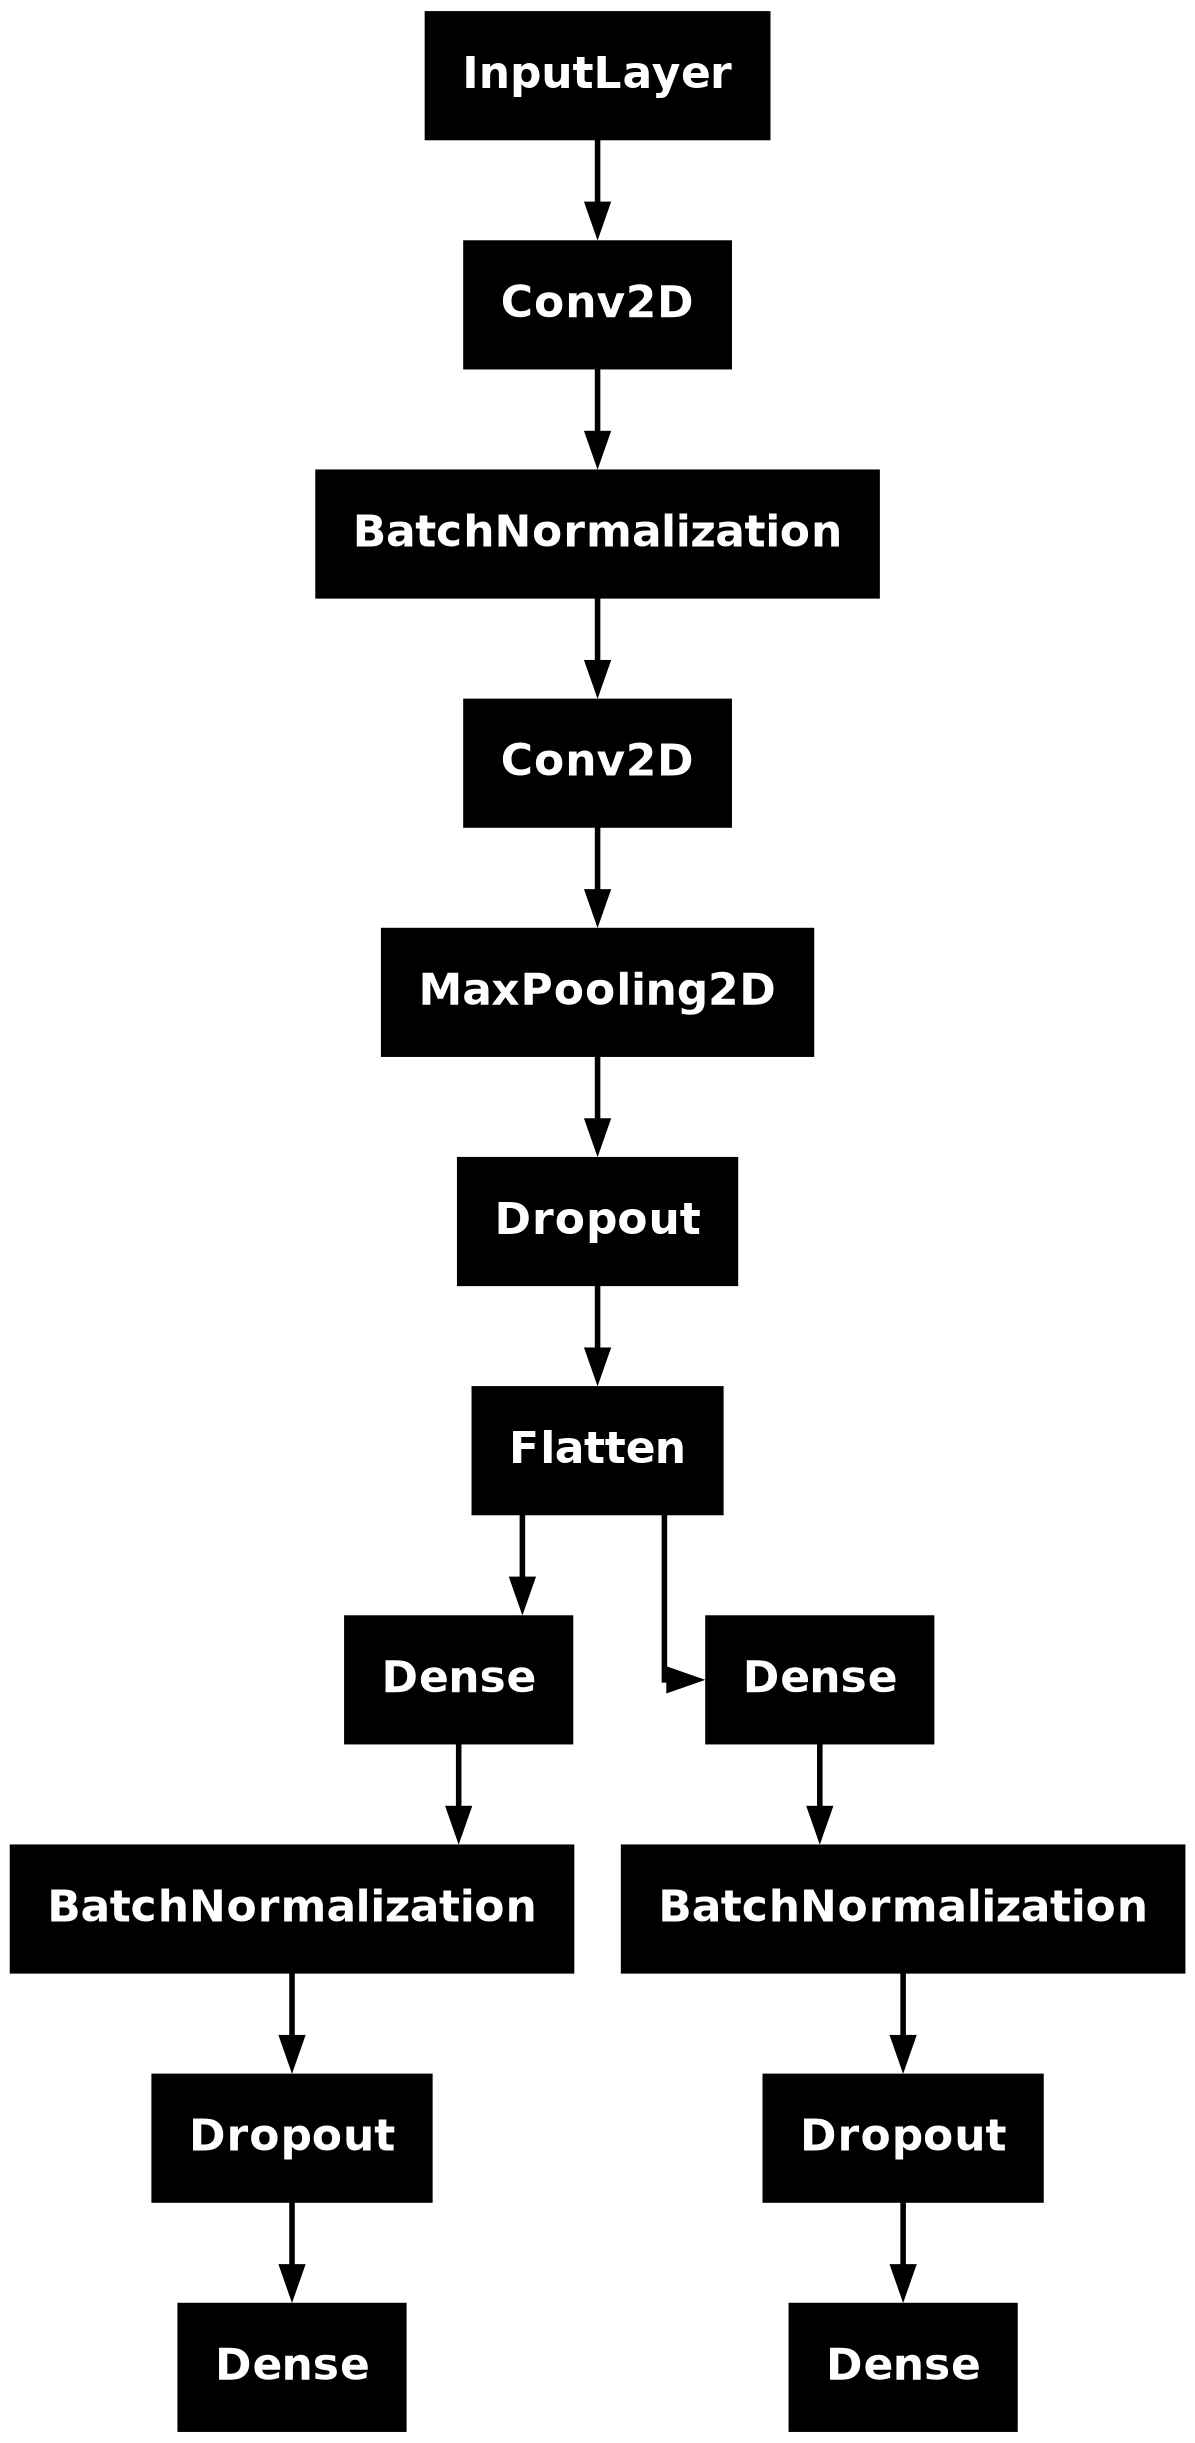

In [15]:
from tensorflow.keras.utils import plot_model
plot_model(model)

# **6-Plot the Results**

<div style="background-color: green; padding: 20px; border-radius: 25px; ">
<font color='white' size="5px">
plot results for gender
    </font>
</div>

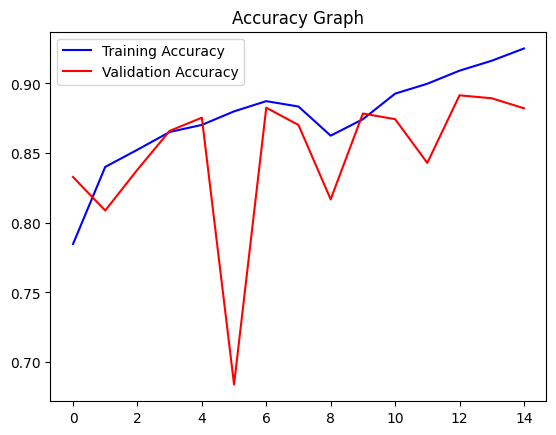

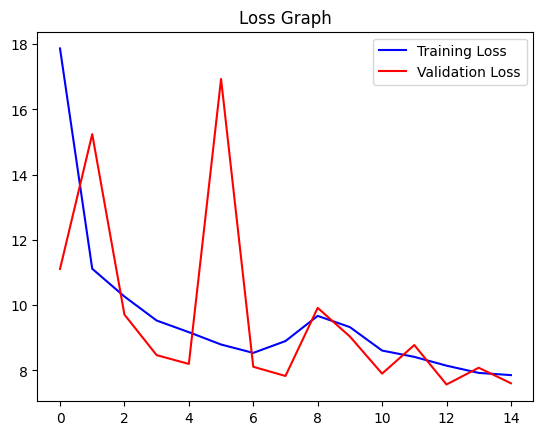

In [16]:
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

<div style="background-color: green; padding: 20px; border-radius: 25px; ">
<font color='white' size="5px">
plot results for age
    </font>
</div>

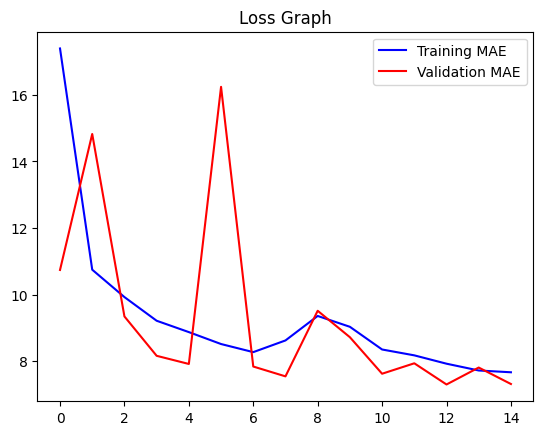

In [17]:
loss = history.history['age_out_mae']
val_loss = history.history['val_age_out_mae']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training MAE')
plt.plot(epochs, val_loss, 'r', label='Validation MAE')
plt.title('Loss Graph')
plt.legend()
plt.show()

# **7-Prediction with Test Data**

Original Gender: Female Original Age: 22
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 781ms/step
Predicted Gender: Female Predicted Age: 26


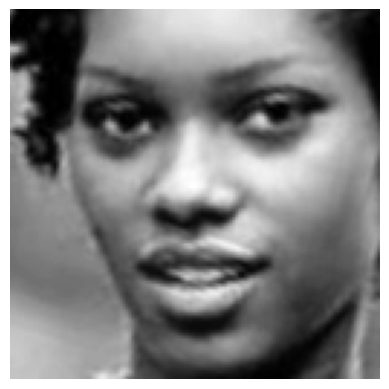

In [18]:
image_index = 50
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Gender: Male Original Age: 54
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicted Gender: Male Predicted Age: 40


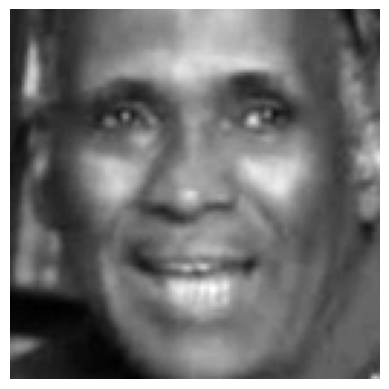

In [19]:
image_index = 500
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

<div style="background-color: green; padding: 20px; border-radius: 25px; ">
<font color='white' size="5px">
save model
    </font>
</div>

In [20]:
model.save("/kaggle/working/Gender_and_Age.h5")